In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')

In [18]:
vvar = ds.vomecrty.isel(y=slice(600,1800), x=slice(200,1400))
vvar.shape

(75, 1200, 1200)

In [13]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = ds.vomecrty.isel(y=slice(600,1800), x=slice(200,1400)).rolling(y=10).mean()
uvar = ds.vozocrtx.isel(y=slice(600,1800), x=slice(200,1400)).rolling(x=10).mean()
uv = ds.vel.isel(y=slice(600,1800), x=slice(200,1400)).rolling(x=10).mean()
uv = uv.rolling(y=10).mean()

In [19]:
vvar = ds.vomecrty.isel(y=slice(600,1800), x=slice(200,1400)).rolling(y=10).mean()
vvar.shape

(75, 1200, 1200)

In [10]:
# chooseing a level to look at 
level_list = [0, 7, 14, 20, 35, 50, 60]
depth_list = np.zeros(7)
for i, level in enumerate(level_list):
    depth = ds.depth[level].values
    depth_list[i] = depth
print(depth_list)

[5.05760014e-01 9.82275009e+00 3.08745613e+01 6.90216827e+01
 3.33862823e+02 1.51636365e+03 3.13856494e+03]


In [12]:
'A funcktion for constructing PC at a given level '
def PC_funk(level):
    warnings.filterwarnings('ignore')
    
    dx = 20
    dy = 20
    # Making empty list with size as data-points 
    jmax, imax = uv[0].shape #fetches the max value in j and i direction 
    i_list = np.arange(0,imax,dx)
    j_list = np.arange(0,jmax,dy)
    
    # Making the covmatrix and finding the eigenvalues and eigenvectors
    # list of all the points for the PC-crosses
    'Dont remember how I got to this number, so dont know how to change the number of points in each PC'
    PC11 = []
    PC12 = []
    PC21 = []
    PC22 = []
    y = []
    x = []
    indx = 0
    
    # to get the loop to run faster
    uvy = np.array(uv.y.values)
    uvx = np.array(uv.x.values)
    
    # fetching the varaibel at the given level 
    uvar_depth = np.array(uvar[level,:,:].values)
    vvar_depth = np.array(vvar[level,:,:].values)
    uv_depth = np.array(uv[level,:,:].values)
    
    for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
            [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                values, vectors = np.linalg.eig(covm)
                PC11.append(vectors[0,0]*np.sqrt(values[0]))
                PC12.append(vectors[1,0]*np.sqrt(values[0]))
                PC21.append(vectors[0,1]*np.sqrt(values[1]))
                PC22.append(vectors[1,1]*np.sqrt(values[1]))
                y.append(uvy[j])
                x.append(uvx[i])
                indx = indx + 1
                
    # converting to np.arrays
    PC11 = np.array(PC11,dtype=float)
    PC12 = np.array(PC12,dtype=float)
    PC21 = np.array(PC21,dtype=float)
    PC22 = np.array(PC22,dtype=float)
    y = np.array(y,dtype=float)
    x = np.array(x,dtype=float)
    
    # smoothening the data
    #PC11 = running_mean(PC11, 10)
    #PC12 = running_mean(PC12, 10)
    #PC21 = running_mean(PC21, 10)
    #PC22 = running_mean(PC22, 10)
    
    return PC11, PC12, PC21, PC22, x, y 

PC11 = running_mean(PC11, 10)
PC12 = running_mean(PC12, 10)
PC21 = running_mean(PC21, 10)
PC22 = running_mean(PC22, 10)

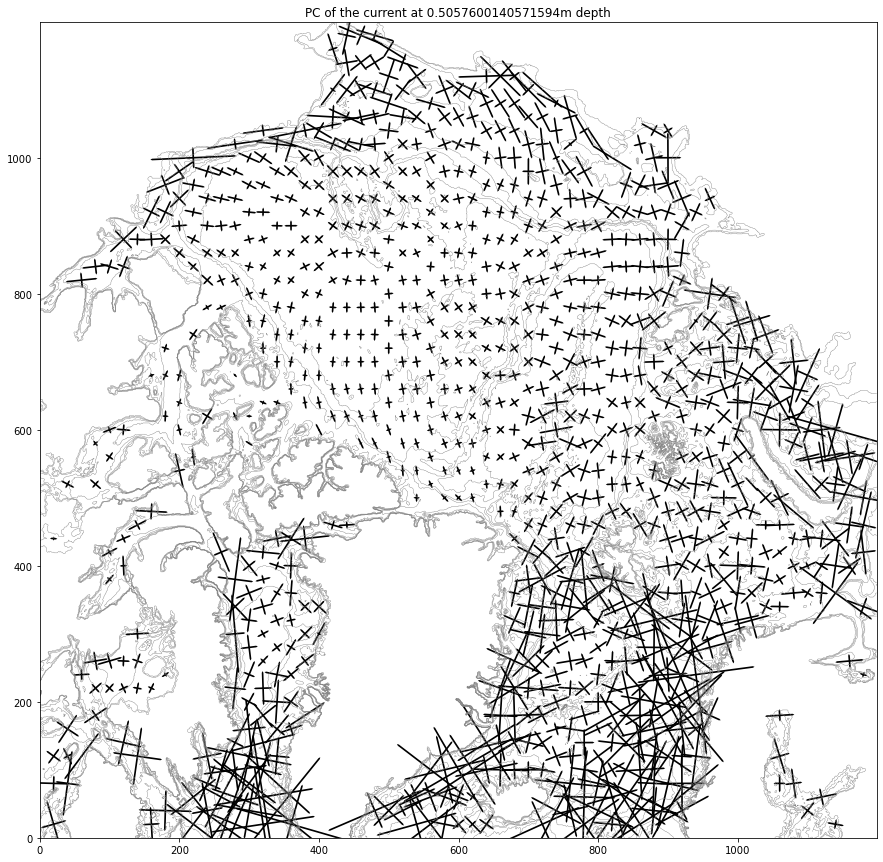

In [17]:
# Plot level 1
n = 0
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(ds.mbathy[600:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)

plt.show()

In [ ]:
# Plot level 2
n = 1
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(ds.mbathy[600:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11_s[::1], PC12_s[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::1], y[::1], -PC11_s[::1], -PC12_s[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], PC21_s[::1], PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], -PC21_s[::1], -PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)


NameError: name 'dset' is not defined

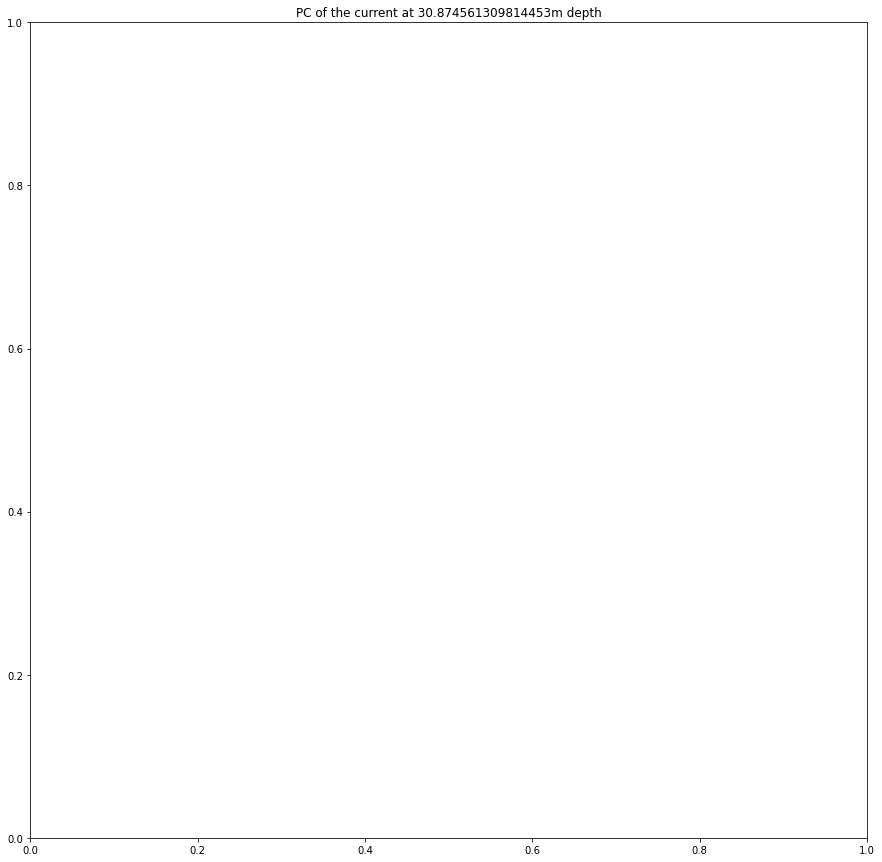

In [16]:
# Plot level 3
n = 2
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(ds.mbathy[600:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11_s[::1], PC12_s[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::1], y[::1], -PC11_s[::1], -PC12_s[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], PC21_s[::1], PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], -PC21_s[::1], -PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)



In [ ]:
# Plot level 4
n = 3
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(ds.mbathy[600:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11_s[::1], PC12_s[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::1], y[::1], -PC11_s[::1], -PC12_s[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], PC21_s[::1], PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], -PC21_s[::1], -PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)



In [ ]:
# Plot level 5
n = 4
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(ds.mbathy[600:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11_s[::1], PC12_s[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::1], y[::1], -PC11_s[::1], -PC12_s[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], PC21_s[::1], PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::1], y[::1], -PC21_s[::1], -PC22_s[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)

